# An automated pipeline to create an atlas of in-situ hybridization gene expression data in the adult marmoset brain (ISBI 2023, Poon, C., et al.)

## 2D registration code

In [1]:
import os
import matplotlib as mpl
import sys
sys.path.append("/disk/soft/SLURM/slurm/")
from slurm import slurm_tools
from IPython.display import clear_output
import numpy as np
import nibabel as nib
import json
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageFile
import cv2
import time
from scipy import ndimage, misc
%load_ext autoreload
%autoreload 2
from skimage import exposure
import skimage
from skimage.transform import rescale, resize, downscale_local_mean
dpi_default = mpl.rcParams['figure.dpi']
from skimage.transform import resize, rescale
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
import scipy
import imageio

def json_write(data,filename):
        with open(filename, 'w') as data_file:
            json.dump(data, data_file, indent=4, sort_keys=True, separators=(',', ':'))

def json_read(filename):
        if (os.path.isfile(filename)):
            with open(filename) as data_file:
                data = json.load(data_file)
            isfile=True;
        else:
            data={}
            isfile=False;
        return data, isfile

def imresize(arr,size, resample=0):   
    if resample == Image.NEAREST:
        interpolation = cv2.INTER_NEAREST
    if resample == Image.LANCZOS:
        interpolation = cv2.INTER_LANCZOS4
    if resample == Image.BICUBIC:
        interpolation = cv2.INTER_CUBIC
    if resample == Image.LINEAR:
        interpolation = cv2.INTER_LINEAR

    size_ = size.copy()
    size_[1], size_[0] = size_[0],size_[1]
    return cv2.resize(arr,(size[1],size[0]),interpolation=interpolation)

def cmp2indx(cm,ind=None):
    if ind is None:
        cm_ = cm.split("/")[-1].replace(".png","").split("_")
        section = int(cm_[0])
        cmp = int(cm_[1])
    else:
        cmp = ind
        section = cm
    return (cmp-1)*12+(section-1)

def indx2cmp(ind):
    cmp = ind % 12 + 1
    i = ind // 12 + 1
    return "{:02d}_{:02d}".format(cmp,i)



print(cmp2indx("01_03"))

24


### 1. Make blockface MIP

In [2]:
# 1. reading in bf images #

"""goal: determine actual bb of bf image
sort them (might be not necessary)
compute mean intensity projection"""

def make_bf_mip(bf_files):   
    
    print("----- in 1 make_bf_mip for mid: "+mid)
    
    bf_indx = np.argsort([cmp2indx(f) for f in bf_files])
    bf_files_ = [bf_files[a] for a in bf_indx]

    init = True
    for f in bf_files_:

        img = imageio.imread(f).mean(axis=2)/255.0
        mask = imageio.imread(f.replace("blockface_raw2","blockface_mask2"))[...,0]>0

        if init:
            init = False
            img_ = np.zeros(img.shape)
        img_ += mask*img
        
        # char addition to increase intensity of cerebellum
        if int(f.split('_')[-1].split('.')[0]) > 60:
            img_ += mask*img*2

    img_mip = img_ / len(bf_files_)
    
    plt.imshow(img_mip, vmin=0, vmax=1)
    plt.title('img_mip')
    plt.show()
    
    return(bf_files_, img_mip)


### 2. Make 3D blockface stack

In [3]:
# 2. 
def create_bf_3d_stack(mu_bf, bf_files_, img_mip):
    
    print("----- in 2 create_bf_3d_stack for mid: "+mid)
    
    pad_size = 100
    # pad size of BF images 
    target_res = 25
    # target resolution of bf images

    valid_mask = img_mip>0.05  #char changed, 0.2
    crop_y = np.argwhere(valid_mask.max(axis=0)>0.5)[[0,-1]]
    crop_x = np.argwhere(valid_mask.max(axis=1)>0.5)[[0,-1]]

    bf_scale = mu_bf/target_res

    valid_mask_cropped = valid_mask[crop_x[0][0]:crop_x[1][0],crop_y[0][0]:crop_y[1][0]]
    new_shape = (np.array(valid_mask_cropped.shape)*bf_scale).astype(np.int32)

    cropped_mask = imresize(valid_mask_cropped.astype(np.float32),new_shape)
    
    plt.imshow(cropped_mask)
    plt.show()
    cropped_mask = np.pad(cropped_mask,[pad_size,pad_size])

    if True:
        for findx,f in zip(range(len(bf_files_)),bf_files_):
            img = imageio.imread(f).mean(axis=2)/255.0
            mask = imageio.imread(f.replace("blockface_raw2","blockface_mask2"))[...,0]>0

            img = equalize_adapthist(img)#[:,:,None]
            tmp = (img*mask)[crop_x[0][0]:crop_x[1][0],crop_y[0][0]:crop_y[1][0]]
            img_t = imresize(tmp,new_shape)
            img_t = np.pad(img_t,[pad_size,pad_size])*cropped_mask

            if findx == 0:
                img_3D = np.zeros([img_t.shape[0],img_t.shape[1],len(bf_files_)],dtype=np.uint8)
            img_3D[:,:,findx] = (img_t*255).astype(np.uint8)

    return img_3D

### 3. Filter and write blockface images as niftis

In [4]:
# 3. 
def filter_write_bf(img_3D, target_res, bf_files_, mid):
    
    print("----- in 3 filter_write_bf for mid: "+mid)
    
    bf_dir = workdir+mid+"/bf/"

    mpl.rcParams['figure.dpi'] = dpi_default 
    plt.imshow(img_3D.max(axis=1)>0)
    plt.savefig(mid+'.png')
    plt.show()
    #mpl.rcParams['figure.dpi'] = dpi_default
    img_3D_ = scipy.ndimage.median_filter(img_3D,[3,3,7])
    plt.imshow(img_3D_.max(axis=1)>0)
    plt.show()


    for findx,f in zip(range(len(bf_files_)),bf_files_):
        mat = np.eye(4)
        mat[0,0] = target_res
        mat[1,1] = target_res

        tmp = img_3D_[:,:,findx]
        tmp = tmp[:,:,None]

        new_image = nib.Nifti1Image(tmp[:,:,0], affine=mat)
        new_image.header.set_xyzt_units(2)
        new_image.header["dim"][0] = 2
        new_image.header["sform_code"] = 1
        new_image.header["pixdim"][4:] = 0
        nib.save(new_image,bf_dir+"/img_"+str(findx+10000)+".nii.gz") 
        

### 4. Create niftis of backlit and gene images

In [ ]:
# 4. 
def create_bl_gene_niis(mid):
    
    print("----- in 4 create_bl_gene_niis for mid: "+mid)
    
    target_res_mi = target_res
    intensity_t = 0.2

    sdir = db+mid+"/img2d/"
    cmpnt = glob.glob(sdir+"/compartments/*_*")
    cmpnt.sort()
    #print(cmpnt)
    stack = []
    for c in cmpnt:
        cds = c.split("/")[-1]                           # component name (eg, 02_gene)
        cds_name = cds.split('_')[-1]                    # component name (eg, gene) 
        print(cds)
        cdi = int(cds.split("_")[0])                     # component number (eg, 2)
        img_fn = glob.glob(c+"/*.png")
        img_fn.sort()
        o_dir = workdir+mid+"/"+cds
        os.makedirs(o_dir,exist_ok=True)
        #print('o_dir:', o_dir)
        
        for f in img_fn:
            
            if "backlit" in cds_name:
                #continue
                #break
                continue
                print('in backlit')
                img = imageio.imread(f)
                bl_scale = mu_bl/target_res_mi
                #new_shape = (np.array(img.shape)*bl_scale).astype(np.int32)
                #img_t = imresize(img,new_shape,Image.LINEAR)
                img_t = rescale(img, bl_scale, anti_aliasing=True)
                #img_t = equalize_adapthist(img_t)
                
                img_t = np.min(img_t,axis=2)


                mask = skimage.morphology.remove_small_objects(img_t<intensity_t,16)
                mask = skimage.morphology.binary_dilation(mask,np.ones([15,15]))
                white = np.maximum(np.maximum(np.maximum(img_t[0,0],img_t[-1,-1]),img_t[0,-1]),img_t[-1,0])
                img_t[mask] = white

                w_scale = 1.0/(white-intensity_t)
                #print(w_scale)
                #w_offset = 1.0-white
                img_t = np.maximum(np.minimum((img_t-intensity_t)*w_scale,1.0),0.0)
                #img_t /= 1.0 - 
            
                

                if True:
                    mat = np.eye(4)
                    mat[0,0] = target_res_mi
                    mat[1,1] = target_res_mi
                    if True:
                        pass
                    else:
                        new_img = np.zeros(bl_shape)
                        c_shape = np.array(img_t.shape[:2])
                        new_img[...] = np.maximum(np.maximum(np.maximum(img_t[0,0],img_t[-1,-1]),img_t[0,-1]),img_t[-1,0])#np.max(np.maximum(np.maximum(np.maximum(img[0,0,:],img[-1,-1,:]),img[0,-1,0]),img[-1,0,:]))
                        offset = (bl_shape-c_shape)//2
                        new_img[offset[0]:offset[0]+c_shape[0],offset[1]:offset[1]+c_shape[1]] = img_t#[...,0]
                        img_t = new_img 


                    new_image = nib.Nifti1Image(img_t, affine=mat)
                else:
                    mat = np.eye(3)
                    mat[0,0] = target_res_mi
                    mat[1,1] = target_res_mi
                    #break
                    img_t = equalize_adapthist(img_t)
                    img_t = (img_t*255).astype(np.uint8)
                    #img_t = np.maximum(img_t.max()-img_t,0)

                    new_image = nib.Nifti1Image(img_t, affine=mat)

                new_image.header.set_xyzt_units(2)
                new_image.header["dim"][0] = 2
                new_image.header["sform_code"] = 1
                new_image.header["pixdim"][4:] = 0

                s_id = int(f.split("/")[-1].replace(".png",""))
                bl_index = cmp2indx(cdi,s_id+1)
                nib.save(new_image,o_dir+"/img_"+str(10000+bl_index)+".nii.gz") 

            else:

                img = imageio.imread(f)
                bl_scale = mu_bl/target_res_mi
                new_shape = (np.array(img.shape)*bl_scale).astype(np.int32)

                img_r = rescale(img[...,0], bl_scale, anti_aliasing=True)
                img_g = rescale(img[...,1], bl_scale, anti_aliasing=True)
                img_b = rescale(img[...,2], bl_scale, anti_aliasing=True)
                img_t = np.concatenate((img_r[...,None],img_g[...,None],img_b[...,None]),axis=2)
                #img_t = img_t*1
                #print('img_t:', img_t.shape, img_t.dtype)
                
                
                if True:  # char adaptation
                    gray = cv2.cvtColor(img_t.astype(np.float32), cv2.COLOR_BGR2GRAY)
                    thresh = threshold_triangle(gray)
                    binary = gray < thresh
                    eroded = skimage.morphology.dilation(binary)


                    # connected component analysis
                    nb, output, stats, centroids = cv2.connectedComponentsWithStats(eroded.astype(np.uint8), 4)

                    meanvali = np.where(stats[:,-1] > stats[:,-1].mean())

                    for i in range(len(meanvali[0])-1):    
                        componentMask = (output == meanvali[0][i+1]).astype("uint8") * 255
                        print(componentMask.shape)
                        if i==0:
                            componentMask_all = componentMask
                        else:
                            componentMask_all = np.add(componentMask_all,componentMask)
                    img_r[componentMask_all==0]=img_r[componentMask_all==0].mean()
                    img_g[componentMask_all==0]=img_g[componentMask_all==0].mean()
                    img_b[componentMask_all==0]=img_b[componentMask_all==0].mean()
                    img_t = np.concatenate((img_r[...,None],img_g[...,None],img_b[...,None]),axis=2)
                    
                    if int(f.split('/')[-1][:-4]) % 10 == 0:
                        plt.imshow(img_t)
                        plt.title('img_t')
                        plt.show()

                        plt.imshow(img_t, cmap='gray')
                        plt.title('result')
                        plt.show()
                
                
                if False:  # original
                    img_t_g = np.min(img_t,axis=2)
                    mask = skimage.morphology.remove_small_objects(img_t_g<intensity_t,16)
                    mask = skimage.morphology.binary_dilation(mask,np.ones([15,15]))
                    mask = (mask*(1-(img_b>img_g)))>0.5                                                # henrik addition sept 2022
                    mask_rgb = np.concatenate((mask[...,None],mask[...,None],mask[...,None]),axis=2)
                    img_t[mask] = np.maximum(np.maximum(np.maximum(img_t[0,0],img_t[-1,-1]),img_t[0,-1]),img_t[-1,0])

                if False:
                    new_shape = np.maximum(np.array(img_t.shape[:2]),bl_shape)
                    new_img = np.zeros([new_shape[0],new_shape[1],3])
                    c_shape = np.array(img_t.shape[:2])
                    new_img[...] = np.max(np.maximum(np.maximum(np.maximum(img_t[0,0,:],img_t[-1,-1,:]),img_t[0,-1,:]),img_t[-1,0,:]))
                    offset = (new_shape-c_shape)//2
                    new_img[offset[0]:offset[0]+c_shape[0],offset[1]:offset[1]+c_shape[1],:] = img_t
                    img_t = new_img 

                mat = np.eye(4)
                mat[0,0] = target_res_mi
                mat[1,1] = target_res_mi


                for r in ["R","G","B","","RGB"]:  # 
                    if r == "":
                        img_g = np.min(img_t,axis=2)
                        new_image = nib.Nifti1Image(img_g, affine=mat)
                        new_image.header["dim"][0] = 2
                    if r == "R":
                        img_g = img_t[...,0]
                        new_image = nib.Nifti1Image(img_g, affine=mat)
                        new_image.header["dim"][0] = 2
                    if r == "G":
                        img_g = img_t[...,1]
                        new_image = nib.Nifti1Image(img_g, affine=mat)
                        new_image.header["dim"][0] = 2
                    if r == "B":
                        img_g = img_t[...,2]
                        new_image = nib.Nifti1Image(img_g, affine=mat)
                        new_image.header["dim"][0] = 2
                    if r == "RGB":
                        img_g = img_t
                        new_image = nib.Nifti1Image(img_g, affine=mat)
                        new_image.header["dim"][0] = 3

                    new_image.header.set_xyzt_units(2)
                    new_image.header["sform_code"] = 1
                    new_image.header["pixdim"][4:] = 0
                    #break
                    s_id = int(f.split("/")[-1].replace(".png",""))
                    bl_index = cmp2indx(cdi,s_id+1)

                    nib.save(new_image,o_dir+"/img"+r+"_"+str(10000+bl_index)+".nii.gz") 
                    #print('saved'+o_dir+"/img"+r+"_"+str(10000+bl_index)+".nii.gz")


### 5. Create niftis of segmented gene images

In [ ]:
# 5. 
def create_geneseg_niis(mid):
    
    print("----- in 5 create_geneseg_niis for mid: "+mid)
    
    target_res_mi = target_res
    intensity_t = 0.2

    sdir = db+mid+"/img2d/"
    cmpnt = glob.glob(sdir+"/compartments_mask/*_*")  # <--
    cmpnt.sort()
    #print(cmpnt)
    stack = []
    for c in cmpnt:
        cds = c.split("/")[-1]
        cds_name = cds.split('_')[-1]
        #print('cds:',cds)
        cdi = int(cds.split("_")[0])
        #input('Continue?')
        img_fn = glob.glob(c+"/*.png")
        img_fn.sort()
        o_dir = workdir+mid+"/"+cds+'_seg'  # <--
        os.makedirs(o_dir,exist_ok=True)
        for f in img_fn:

            img = imageio.imread(f)
            bl_scale = mu_bl/target_res_mi
            new_shape = (np.array(img.shape)*bl_scale).astype(np.int32)
            
            img_r = rescale(img[...], bl_scale, anti_aliasing=True)
            img_g = rescale(img[...], bl_scale, anti_aliasing=True)
            img_b = rescale(img[...], bl_scale, anti_aliasing=True)
            img_t = np.concatenate((img_r[...,None],img_g[...,None],img_b[...,None]),axis=2)
            #img_t = img_t*1
            img_t_g = np.min(img_t,axis=2)
            

            mat = np.eye(4)
            mat[0,0] = target_res_mi
            mat[1,1] = target_res_mi


            for r in ["R","G","B",""]:
                if r == "":
                    img_g = np.min(img_t,axis=2)
                if r == "R":
                    img_g = img_t[...]
                if r == "G":
                    img_g = img_t[...]
                if r == "B":
                    img_g = img_t[...]
                new_image = nib.Nifti1Image(img_g, affine=mat)

                new_image.header.set_xyzt_units(2)
                new_image.header["dim"][0] = 2
                new_image.header["sform_code"] = 1
                new_image.header["pixdim"][4:] = 0
                #break
                s_id = int(f.split("/")[-1].replace(".png",""))
                bl_index = cmp2indx(cdi,s_id+1)

                nib.save(new_image,o_dir+"/img"+r+"_"+str(10000+bl_index)+".nii.gz") 


### 6. Align backlit images to blockfaces images

In [5]:
# 6. Create aligned backlit image stack
def align_bl(mid):
    
    print("----- in 6 align_bl for mid: "+mid)
    
    cmp = "01_backlit"
    cmp_dir = workdir+mid+"/"+cmp+"/"

    bf_dir = workdir+mid+"/bf/"
    backlit_files = glob.glob(cmp_dir+"/*.nii.gz")
    backlit_files.sort()
    bl_ids = np.array([int(c.split("/")[-1].replace("img_","").replace(".nii.gz","")) for c in backlit_files])

    jobids=[] 
    for state in range(11): 
        print('state:', state)
        logfolder = workdir+mid+"/logs/"+str(cmp)+"/"+str(state)+'/'
        os.makedirs(logfolder,exist_ok=True)
        odir = workdir+mid+"/out/"+str(cmp)+"/"+str(state)+'/'
        os.makedirs(odir,exist_ok=True)
        odir_prev = workdir+mid+"/out/"+str(cmp)+"/"+str(state-1)+'/'
        os.makedirs(odir+"/trafo/",exist_ok=True)
        os.makedirs(odir+"/img/",exist_ok=True)

        for z,dind in zip(range(len(bl_ids)),bl_ids):
            bf_img = bf_dir+"img_"+str(dind)+".nii.gz"
            assert(os.path.isfile(bf_img))
            nid = np.argmin(np.abs(bl_ids - dind))
            if nid-1>=0:
                prev_bl = bl_ids[nid-1]
            else:
                prev_bl = bl_ids[nid+1]
            nearest_bl = bl_ids[nid]
            if (nid+1) > (len(bl_ids)-1):
                next_bl = prev_bl
            else:
                next_bl = bl_ids[nid+1]

            FNAME  = "img_"+str(dind)

            clear_output(wait=True)

            if state == 0:
                bl_img_0 = bf_img#cmp_dir+"img_"+str(prev_bl)+".nii.gz"
                bl_img_1 = cmp_dir+"img_"+str(nearest_bl)+".nii.gz"
                bl_img_2 = bf_img#cmp_dir+"img_"+str(next_bl)+".nii.gz"
                PRETRAFO = "["+bf_img+","+bl_img_1+",0]"
                assert(os.path.isfile(bl_img_0))
                assert(os.path.isfile(bl_img_1))
                assert(os.path.isfile(bl_img_2))
            else:
                PRETRAFO = odir_prev+"/trafo/trafo_"+FNAME+"Composite.h5"
                bl_img_1 = cmp_dir+"img_"+str(nearest_bl)+".nii.gz"
                bl_img_0 = odir_prev+"/img/img_"+str(prev_bl)+".nii.gz"
                bl_img_2 = odir_prev+"/img/img_"+str(next_bl)+".nii.gz"
                bl_avg = odir_prev+"/filterd/img_"+str(nearest_bl)+".nii.gz"
                if z>len(bl_ids)//2:
                    REF_BL = bl_img_0
                else:
                    REF_BL = bl_img_2

                assert(os.path.isfile(bl_img_0))
                assert(os.path.isfile(bl_img_1))
                assert(os.path.isfile(bl_img_2))

            SLURM_commands = ["PRETRAFO="+PRETRAFO+" STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_avg1.sh;"]

            if state>0:
                SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_avg2.sh;"]#

            if state>2:
                odir_prev_affine = workdir+mid+"/out/"+str(cmp)+"/"+str(2)+'/'
                PRETRAFO = odir_prev_affine+"/trafo/trafo_"+FNAME+"Composite.h5"
                SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_avg2_3.sh;"]#


            if state>4:
                SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_avg2_4.sh;"]#


            jobid, success = slurm_tools.slurm_submit(SLURM_commands,
                name = str(state)+" "+str(dind),
                output = logfolder+'/log'+str(dind)+'.out',
                mem = '16GB',
                cores = '10',
                partition = "ish-adult",#"bigmem",
                #nodelist = 'bigmem-02',                                      
                )      

            print("job number: "+jobid)

            if not success:
                    print("could not submit jobs")
                    print(format(jobid))
                    print(format(jobids))
                    slurm_tools.killall(jobids)
            jobids.append(int(jobid))
           # break

        print("state "+str(state))
        slurm_tools.wait_for_jobs(jobids)


        time.sleep(5)
        if True:
                for z,dind in zip(range(len(bl_ids)),bl_ids):
                        nid = np.argmin(np.abs(bl_ids - dind))
                        nearest_bl = bl_ids[nid]

                        FNAME  = "img_"+str(dind)

                        odir = workdir+mid+"/out/"+str(cmp)+"/"+str(state)+'/'
                        bl_img_1 = odir+"/img/img_"+str(nearest_bl)+".nii.gz"
                        assert(os.path.isfile(bl_img_1))

                        data = nib.load(bl_img_1)
                        if z == 0:
                            img_3d = np.zeros([data.shape[0],data.shape[1],len(bl_ids)])
                        img_3d[...,z] = data.get_fdata(dtype=np.float32)#*255

                if state<2:
                    img_3ds = skimage.filters.gaussian(img_3d,[3,3,7],mode='constant',cval=1)            
                elif state <5:
                    img_3ds = skimage.filters.gaussian(img_3d,[3,3,5],mode='constant',cval=1)            
                else:
                    img_3ds = skimage.filters.gaussian(img_3d,[3,3,3],mode='constant',cval=1)            
                img_3ds = (img_3ds+np.flip(img_3ds,axis=1))/2.0


                odir_f = workdir+mid+"/out/"+str(cmp)+"/"+str(state)+'/filterd/'
                os.makedirs(odir_f,exist_ok=True)
                for z,dind in zip(range(len(bl_ids)),bl_ids):
                    nid = np.argmin(np.abs(bl_ids - dind))
                    nearest_bl = bl_ids[nid]

                    odir = workdir+mid+"/out/"+str(cmp)+"/"+str(state)+'/'
                    bl_img_1 = odir+"/img/img_"+str(nearest_bl)+".nii.gz"

                    assert(os.path.isfile(bl_img_1))
                    data_ref = nib.load(bl_img_1)

                    bl_img_1 = odir_f+"/img_"+str(nearest_bl)+".nii.gz"

                    img_t = img_3ds[...,z]

                    new_image = nib.Nifti1Image(img_t, affine=data_ref.affine)

                    new_image.header.set_xyzt_units(2)
                    new_image.header["dim"][0] = 2
                    new_image.header["sform_code"] = 1
                    new_image.header["pixdim"][4:] = 0
                    nib.save(new_image,bl_img_1) 
                    print('bl_img_1:', bl_img_1)

### 7. Align raw ISH images to blockface and backlit images

In [10]:
# 7. Create aligned ish raw
def align_ish(mid, cmp_list):

    print("----- in 7 align_ish for mid: "+mid)
    workdir = '/disk/charissa/ISH_reg_pipeline/data/'
    mid = 'R04_0239'

    bl_fil = workdir+mid+"/out/01_backlit/10/filterd/"  #'/01_backlit/'
    bl_fil_f = sorted(glob.glob(bl_fil+'*.nii.gz'))

    cmp_plus = os.listdir(workdir+mid)
    cmp_ls = [x for x in cmp_plus if '_gene' in x and 'seg' not in x]
    cmp_ls = sorted(cmp_ls)
    cmp_ls

    #cmp = "02_gene"

    for cmp in cmp_ls:  #["07","10"]:  # ["02","03","04","05","06","07","08","09","10","11","12"]
        cmp_dir = workdir+mid+"/"+cmp+"/"
        cmp_f = sorted(glob.glob(cmp_dir+'img_*.nii.gz'))
        print('{} in {}'.format(len(cmp_f),cmp))


        bf_dir = workdir+mid+"/bf/"  # "/bl/"  charissa changed this
        backlit_files = glob.glob(cmp_dir+"/img_*.nii.gz")
        backlit_files.sort()
        bl_ids = np.array([int(c.split("/")[-1].replace("img_","").replace(".nii.gz","")) for c in backlit_files])



        jobids=[]  
        for state in [0]:#,1,2]:
            for z in range(len(cmp_f)):
                cmp_nom = cmp_f[z].split('/')[-2]
                FNAME = cmp_f[z].split('/')[-1]

                # make dirs
                odir = workdir+mid+"/out/"+cmp_nom+"/"+str(state)+'/'
                os.makedirs(odir, exist_ok=True)
                odir_im = odir+'/img/'
                os.makedirs(odir_im, exist_ok=True)
                odir_trafo = odir+'/trafo/'
                os.makedirs(odir_trafo, exist_ok=True)
                logfolder = odir+'/log_ish2blstate'+str(state)+'/'
                os.makedirs(logfolder, exist_ok=True)

                OUT = odir_im+FNAME
                POSTTRAFO = odir_trafo+'trafo_'+FNAME[:-7]+"Composite.h5"

                move_n = cmp_f[z]
                fixed_n = bl_fil_f[z]

                print("cmp:{}, \nbl:{}".format(cmp_f[z], bl_fil_f[z]))

                clear_output(wait=True)

                #os.system("sbatch %(POSTTRAFO, OUT, fixed_n, move_n))

                SLURM_commands = ["PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_gene_01.sh;"]
                if state == 0:
                    SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_gene_02.sh;"]#

                if state>0:
                    SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_gene_02.sh;"]#


                if state>1:
                    odir_prev_affine = workdir+mid+"/out/"+str(cmp)+"/"+str(1)+'/'
                    PRETRAFO = odir_prev_affine+"/trafo/trafo_"+FNAME+"Composite.h5"
                    SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_gene_03.sh;"]#

                    
                    
                jobids=[]
                jobid, success = slurm_tools.slurm_submit(SLURM_commands,
                    name = str(state)+" "+FNAME,
                    output = logfolder+'/log'+FNAME+'.out',
                    mem = '256GB',
                    cores = '48',
                    partition = "ish-adult",
                    time="UNLIMITED",
                    )      

                print("job number: "+jobid)

                if not success:
                        print("could not submit jobs")
                        print(format(jobid))
                        print(format(jobids))
                        slurm_tools.killall(jobids)
                jobids.append(int(jobid))
               # break


                slurm_tools.wait_for_jobs(jobids)



            print("state "+str(state))
            slurm_tools.wait_for_jobs(jobids)
        save_filterd_niis(odir_im, state)



### 8. Align segmented ISH images based on transforms from aligning raw ISH images in step 4

In [7]:
# 8. Create aligned ish seg
def align_ish_seg(mid, cmp_ls):
    
    print("----- in 8 align_ish_seg for mid: "+mid)
    
    ref_cmp = "01_backlit"
    ref_cmp_dir = workdir+mid+"/"+ref_cmp+"/"
    ref_files = glob.glob(ref_cmp_dir+"/*.nii.gz")
    ref_files.sort()
    ref_bl_ids = np.array([int(c.split("/")[-1].replace("img_","").replace(".nii.gz","")) for c in ref_files])

    for cmp in cmp_ls:  
        cmp_dir = workdir+mid+"/"+cmp+"/"
        print('cmp_dir:',cmp_dir)

        bf_dir = workdir+mid+"/bf/"  
        backlit_files = glob.glob(cmp_dir+"/img_*.nii.gz")
        backlit_files.sort()
        bl_ids = np.array([int(c.split("/")[-1].replace("img_","").replace(".nii.gz","")) for c in backlit_files])

        jobids=[]  

        state=1
        logfolder = workdir+mid+"/logs/"+str(cmp)+"/"+str(state)+'/'
        os.makedirs(logfolder,exist_ok=True)
        odir = workdir+mid+"/out_seg/"+str(cmp)+"/"+str(state)+'/'
        print('odir: ', odir)
        os.makedirs(odir,exist_ok=True)
        odir_prev = workdir+mid+"/out_seg/"+str(cmp)+"/"+str(state-1)+'/'
        dir_trafo = workdir+mid+"/out/"+str(cmp).split('_seg')[0]+"/"+str(2)+'/'
        print('str(cmp): ',str(cmp))
        print('dir_trafo: ',dir_trafo)

        os.makedirs(odir+"/trafo/",exist_ok=True)
        os.makedirs(odir+"/img/",exist_ok=True)

        if True:
            for z,dind in zip(range(len(bl_ids)),bl_ids):
                bf_img = bf_dir+"img_"+str(dind)+".nii.gz"
                assert(os.path.isfile(bf_img))

                nid = np.argmin(np.abs(bl_ids - dind))      
                if nid-1>=0:
                    prev_bl = bl_ids[nid-1]
                else:
                    prev_bl = bl_ids[nid+1]
                nearest_bl = bl_ids[nid]
                if (nid+1) > (len(bl_ids)-1):
                    next_bl = prev_bl
                else:
                    next_bl = bl_ids[nid+1]

                nid = np.argmin(np.abs(ref_bl_ids - dind))  
                nearest_ref = ref_bl_ids[nid]

                FNAME  = "img_"+str(dind)

                clear_output(wait=True)

                odir_ref = workdir+mid+"/out/01_backlit/10/"
                print('odir_ref: ',odir_ref)

                bf_img = odir_ref+"/filterd/"+"img_"+str(nearest_ref)+".nii.gz"  # not used

                bl_img_1 = cmp_dir+"img_"+str(nearest_bl)+".nii.gz"
                bl_img_0 = cmp_dir+"img_"+str(prev_bl)+".nii.gz"
                bl_img_2 = cmp_dir+"img_"+str(next_bl)+".nii.gz"
                bl_avg = odir_ref+"/filterd/img_"+str(nearest_bl)+".nii.gz"
                if z>len(bl_ids)//2:
                    REF_BL = bl_img_0
                else:
                    REF_BL = bl_img_2

                assert(os.path.isfile(bl_img_0))
                assert(os.path.isfile(bl_img_1))
                assert(os.path.isfile(bl_img_2))

                PRETRAFO = dir_trafo+"/trafo/trafo_"+FNAME+"Composite.h5"
                print('dir_trafo: ',dir_trafo)
                print('FNAME: ',FNAME)
                print('PRETRAFO: ', PRETRAFO)
                SLURM_commands = ["FIL="+bl_avg+" REF_BL="+REF_BL+" PRETRAFO="+PRETRAFO+"  STATE="+str(state)+"  ODIR="+odir+"  FNAME="+FNAME+"  BF="+bf_img+" BL1="+bl_img_1+"  BL0="+bl_img_0+"  BL2="+bl_img_2+" bash regme_gene_03_seg.sh;"]#

                jobid, success = slurm_tools.slurm_submit(SLURM_commands,
                    name = str(state)+" "+str(dind),
                    output = logfolder+'/log'+str(dind)+'.out',
                    mem = '16GB',
                    cores = '10',
                    nodelist = 'bigmem-02',                                      
                    )      

                print("job number: "+jobid)

                if not success:
                        print("could not submit jobs")
                        print(format(jobid))
                        print(format(jobids))
                        slurm_tools.killall(jobids)
                jobids.append(int(jobid))

            print("state "+str(state))
            slurm_tools.wait_for_jobs(jobids)


        # to make filtered images/stack
        if True:
            time.sleep(5)
            #state = 0
            for z,dind in zip(range(len(bl_ids)),bl_ids):

                nid = np.argmin(np.abs(bl_ids - dind))
                nearest_bl = bl_ids[nid]

                FNAME  = "img_"+str(dind)

                odir = workdir+mid+"/out_seg/"+str(cmp)+"/"+str(state)+'/'
                os.makedirs(odir,exist_ok=True)
                #bl_img_1 = cmp_dir+"img_"+str(nearest_bl)+".nii.gz"
                bl_img_1 = odir+"/img/img_"+str(nearest_bl)+".nii.gz"
                assert(os.path.isfile(bl_img_1))

                data = nib.load(bl_img_1)
                if z == 0:
                    img_3d = np.zeros([data.shape[0],data.shape[1],len(bl_ids)])
                img_3d[...,z] = data.get_fdata(dtype=np.float32)#*255

            img_3ds = skimage.filters.gaussian(img_3d,[3,3,3],mode='constant',cval=1)            
            img_3ds = (img_3ds+np.flip(img_3ds,axis=1))/2.0


            odir_f = workdir+mid+"/out_seg/"+str(cmp)+"/"+str(state)+'/filterd/'
            os.makedirs(odir_f,exist_ok=True)
            for z,dind in zip(range(len(bl_ids)),bl_ids):

                nid = np.argmin(np.abs(bl_ids - dind))
                nearest_bl = bl_ids[nid]

                odir = workdir+mid+"/out_seg/"+str(cmp)+"/"+str(state)+'/'
                bl_img_1 = odir+"/img/img_"+str(nearest_bl)+".nii.gz"
                assert(os.path.isfile(bl_img_1))
                data_ref = nib.load(bl_img_1)

                bl_img_1 = odir_f+"/img_"+str(nearest_bl)+".nii.gz"

                #img_t = (np.minimum(np.maximum(img_3ds[...,z],0),255)).astype(np.uint8)
                img_t = img_3ds[...,z]

                new_image = nib.Nifti1Image(img_t, affine=data_ref.affine)

                new_image.header.set_xyzt_units(2)
                new_image.header["dim"][0] = 2
                new_image.header["sform_code"] = 1
                new_image.header["pixdim"][4:] = 0
                nib.save(new_image,bl_img_1) 
            time.sleep(5)

## Run 2d registration on a list of marmoset IDs

### Get a list of marmoset IDs

In [8]:
# get all marmoset folders with blockface images
root = '/disk/charissa/shimogori_adult/'
marm_ls = []
for marm_dir in os.listdir(root):
    if os.path.isdir(os.path.join(root, marm_dir)) and 'R0' in marm_dir:
        if os.path.exists(os.path.join(root,marm_dir)+'/img2d/blockface_raw/'):
            marm_ls.append(marm_dir)
        
marm_ls.sort()

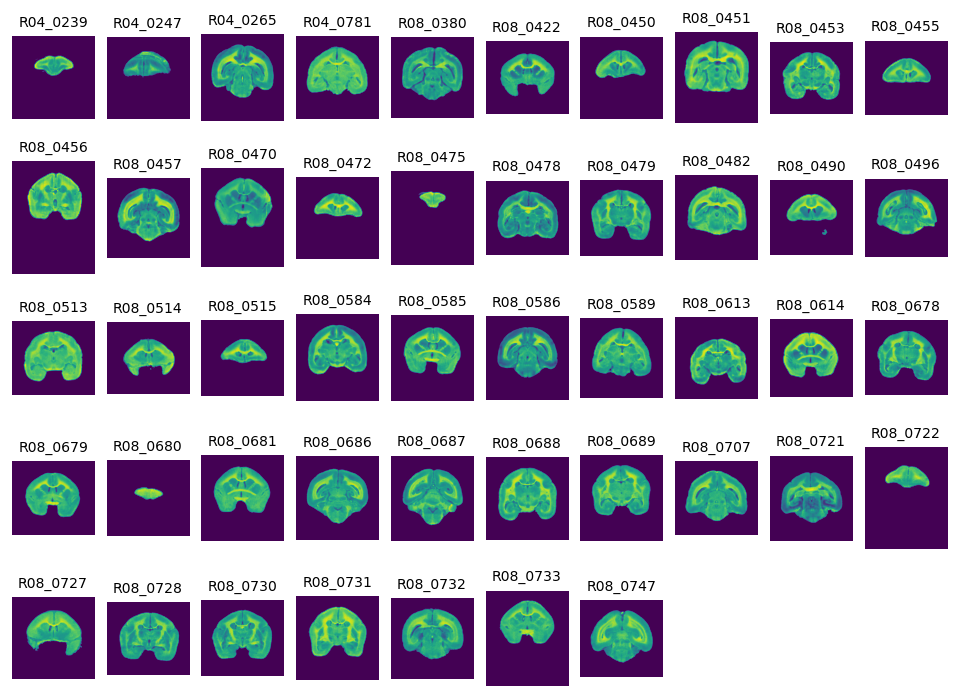

In [70]:
# plot a random slice from each marm
from matplotlib.pyplot import figure
import random
workdir = '/disk/charissa/ISH_reg_pipeline/data/'

figure(figsize=(8, 6), dpi=120)
plt.rcParams.update({'font.size': 7})

for d in range(len(marm_ls)):  # 
    cdir = workdir+marm_ls[d]+'/bf/img_'+str(random.randint(10000,11000))+'.nii.gz'
    nibo = nib.load(cdir)
    nibim = nibo.get_fdata()

    plt.subplot(5,10,d+1)
    plt.imshow(nibim)
    plt.title(marm_ls[d])
    plt.axis('off')

plt.tight_layout()
plt.savefig('bf_masked_20220905.png')
plt.show()

In [ ]:
# call everything, loop try the rest of the data
db = '/disk/charissa/shimogori_adult/'
workdir = '/disk/charissa/ISH_reg_pipeline/data/'
target_res = 25
mu_bl = 3.12

for d in range(len(marm_ls)):
    
    mid = marm_ls[d]
    print(mid)

    mu_bl = 3.12
    mu_bf = 28.72

    print("mu bl:",mu_bl)
    print("mu bf:",mu_bf)

    os.makedirs(workdir+mid+"/bf/",exist_ok=True)

    sdir = db+mid+"/img2d/"
    bf_files = glob.glob(sdir+"/blockface_raw2/*.png")
    bf_files.sort()
    
    bf_files_, img_mip = make_bf_mip(bf_files)  # 1
    img_3D = create_bf_3d_stack(mu_bf, bf_files_, img_mip)  # 2
    filter_write_bf(img_3D, target_res, bf_files_, mid)  # 3
    create_bl_gene_niis(mid)  # 4
    create_geneseg_niis(mid)  # 5
    

    cmp_ls_all = os.listdir(workdir+mid)
    cmp_ls_raw = [m for m in cmp_ls_all if 'gene' in m and 'backlit' not in m and 'seg' not in m]
    cmp_ls_seg = [m for m in cmp_ls_all if 'gene_seg' in m and 'backlit' not in m]
    
    align_bl(mid)  # 6
    align_ish(mid,cmp_ls_raw)  # 7
    align_ish_seg(mid,cmp_ls_seg)  # 8
    

job number: 1154725
state 1
waiting .....
50
50
57
61
67
67
68
68
69
70
75
84
87
92
93
95
96
97
98
